In [8]:
%reset -s -f


In [9]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [10]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [17]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [20]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [28]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

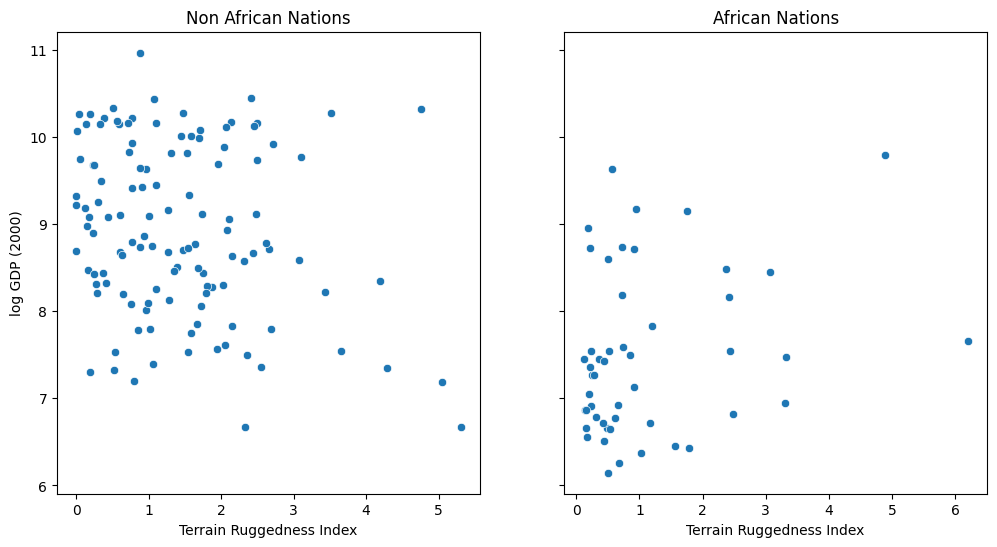

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

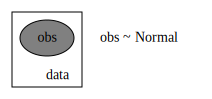

In [30]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

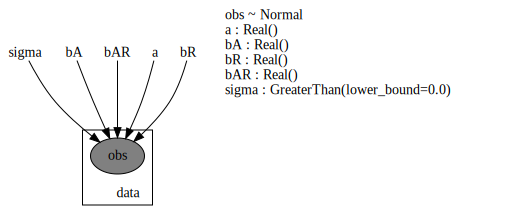

In [31]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)


In [33]:
conditioned_model = pyro.condition(simple_model, data={"obs": log_gdp})


In [34]:
conditioned_model

_bound_partial(<function _context_wrap at 0x71b71d1f1580>, <pyro.poutine.condition_messenger.ConditionMessenger object at 0x71b71ac5f210>, <function simple_model at 0x71b71ac06980>)

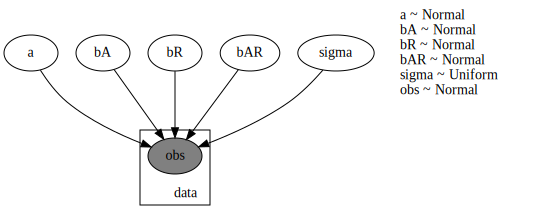

In [48]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

In [36]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(0.))
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, torch.tensor(0.05)))  # fixed scale for simplicity
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

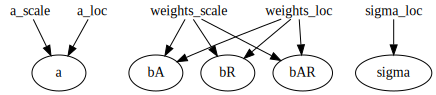

In [37]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)


In [39]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)


In [40]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 694.9404839277267
Elbo loss: 524.3822097182274
Elbo loss: 475.66814661026
Elbo loss: 399.9908837080002
Elbo loss: 315.23268163204193
Elbo loss: 254.76768797636032
Elbo loss: 248.23704081773758
Elbo loss: 248.42670565843582
Elbo loss: 248.46450597047806
Elbo loss: 257.41463327407837


CPU times: user 6.12 s, sys: 54.6 ms, total: 6.17 s
Wall time: 6.18 s


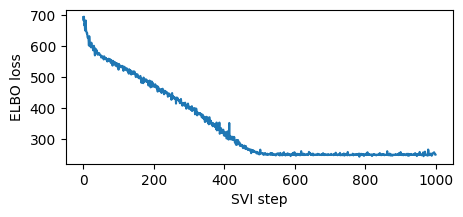

In [41]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [42]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.07036691
AutoNormal.locs.bA -1.8474661
AutoNormal.scales.bA 0.1407009
AutoNormal.locs.bR -0.19032119
AutoNormal.scales.bR 0.044044245
AutoNormal.locs.bAR 0.3559977
AutoNormal.scales.bAR 0.07937442
AutoNormal.locs.sigma -2.205863
AutoNormal.scales.sigma 0.060526706


In [44]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

In [45]:
samples

{'a': tensor([9.2791, 9.2204, 9.2985, 9.2084, 9.1619, 9.2169, 9.2663, 9.1479, 9.2025,
         9.1694, 9.1846, 9.1358, 9.1804, 9.2175, 9.2463, 9.0255, 9.2527, 9.1670,
         9.1697, 9.2359, 9.0220, 9.0582, 9.1445, 9.2170, 9.2299, 9.2916, 9.1553,
         9.1717, 9.1212, 9.2433, 9.0802, 9.1768, 9.0813, 9.1925, 9.1370, 9.1892,
         9.1371, 9.1924, 9.1126, 9.1702, 9.0806, 9.1825, 9.1531, 9.1172, 9.1058,
         9.2833, 9.3545, 9.1617, 9.2621, 9.1719, 9.0287, 9.1841, 9.1170, 9.1187,
         9.2700, 9.1965, 9.2397, 9.1320, 9.1961, 9.1176, 9.2282, 9.0700, 9.0550,
         9.1512, 9.1029, 9.1416, 9.2870, 9.2213, 9.1791, 9.2744, 9.1144, 9.1951,
         9.2689, 9.0925, 9.1838, 9.2425, 9.2076, 9.1733, 9.2444, 9.0792, 9.3048,
         9.1798, 9.1134, 9.1314, 9.2225, 9.2432, 9.1633, 9.2384, 9.1096, 9.0626,
         9.1065, 9.2240, 9.0718, 9.1596, 9.1607, 9.1369, 9.1224, 9.0563, 9.2449,
         9.1211, 9.2267, 9.2612, 9.2024, 9.1061, 9.0998, 9.1496, 9.1682, 9.1844,
         9.2716, 9.0886